# **Importing Modules and Dependencies**

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as data

import random
import numpy as np
import os
import time
import math

import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

from PIL import Image
from torch.autograd import Variable

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Data**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transformer = transforms.Compose([
    transforms.Resize([150,150]),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                         [0.5,0.5,0.5])
])

In [ ]:
root="/content/drive/MyDrive/smart_data_solutions/ML/data"
train_data=datasets.ImageFolder(root=f'{root}/train',
                                  transform=transformer)

test_data = datasets.ImageFolder(root=f'{root}/test',
                                  transform=transformer)

In [ ]:
print(len(train_data))
print(len(test_data))

2004
502


In [ ]:
train_loader=data.DataLoader(train_data,
                             batch_size=32,
                             shuffle=True)

test_loader=data.DataLoader(test_data,
                             batch_size=16,
                             shuffle=True)

In [ ]:
print(len(train_loader))
print(len(test_loader))

63
32


In [ ]:
classes=train_data.classes
print(classes)
num_classes=len(classes)
print(num_classes)

['0', '2', '4', '6', '9']
5


In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

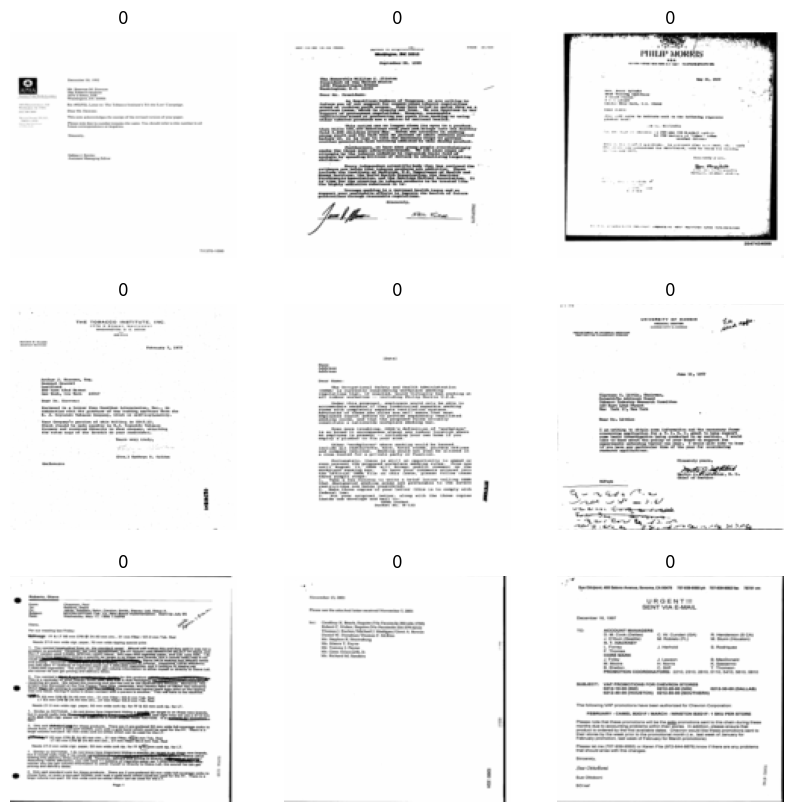

In [ ]:
#for ploting '0' category images

N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

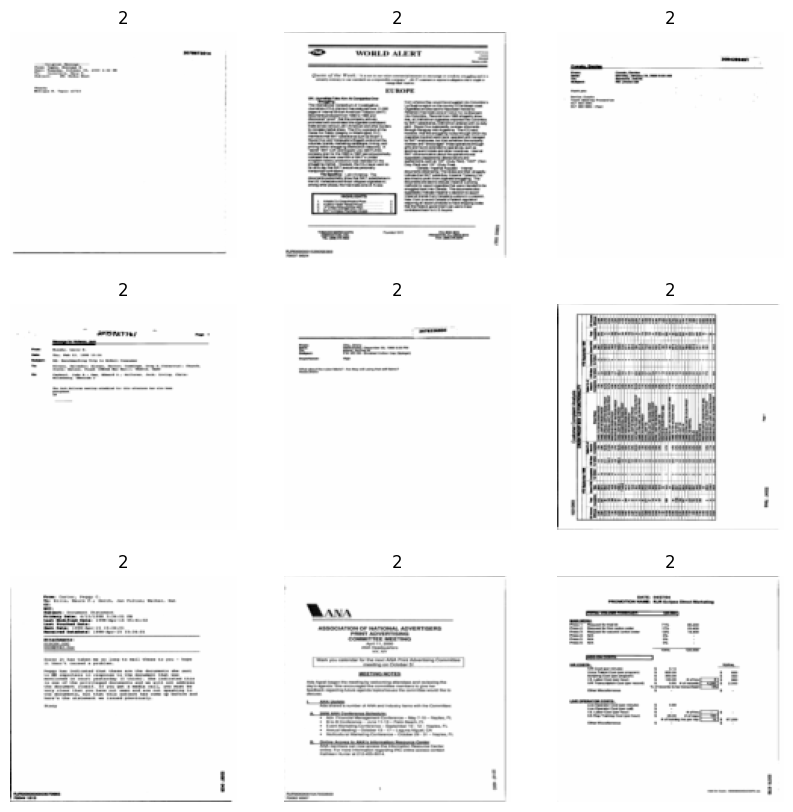

In [ ]:
#for ploting '2' category images

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(400,400+N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

# **ConvNet**

In [ ]:
class ConvNet(nn.Module):
  def __init__(self,num_classses=5):
    super(ConvNet,self).__init__()

    #input shape =(256,1,150,150)
    self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
    #shape (256,12,224,224)

    self.bn1=nn.BatchNorm2d(num_features=12)
    #shape (256,12,224,224)

    self.relu1=nn.ReLU()
    #shape (256,12,224,224)

    self.pool=nn.MaxPool2d(kernel_size=2)
    #reduce the image size by factor of 2
    #shape= (256,12,112,112)

    self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
    #shape (256,20,112,112)

    self.relu2=nn.ReLU()
    #shape (256,20,112,112)

    self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
    #shape (256,32,112,112)

    self.bn3=nn.BatchNorm2d(num_features=32)
    #shape (256,32,112,112)

    self.relu3=nn.ReLU()
    #shape (256,32,112,112)

    self.dropout = nn.Dropout(p=0.5)

    self.fc=nn.Linear(in_features=75*75*32,out_features=num_classes)


  def forward(self,input):
    output=self.conv1(input)
    output=self.bn1(output)
    output=self.relu1(output)

    output=self.pool(output)

    output=self.conv2(output)
    output=self.relu2(output)

    output=self.conv3(output)
    output=self.bn3(output)
    output=self.relu3(output)

    output=self.dropout(output)

    output=output.view(output.size(0),-1)

    output=self.fc(output)

    return output




In [ ]:
model=ConvNet(num_classses=5).to(device)

In [ ]:
#optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 908,401 trainable parameters


In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
from tqdm import tqdm


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    # count=0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        # count=count+1

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # if count==1:
        #   break

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    # count=0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            # count=count+1

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # if count==1:
            #   break

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
num_epochs=10
save_model_path=os.path.join('/content/drive/MyDrive/smart_data_solutions/ML/models/model_convnet.pt')

best_valid_loss = float('inf')

total_train_loss=[]
total_val_loss=[]

total_train_accuracy=[]
total_val_accuracy=[]

for epoch in trange(num_epochs,desc='Epochs'):
    
    start_time=time.monotonic()

    train_loss,train_accuracy=train(model,train_loader, optimizer,criterion,device)
    total_train_loss.append(train_loss)
    total_train_accuracy.append(train_accuracy)
    
    evaluate_loss,val_accuracy=evaluate(model,test_loader,criterion,device)
    total_val_loss.append(evaluate_loss)
    total_val_accuracy.append(val_accuracy)

    if evaluate_loss<best_valid_loss:
        best_valid_loss=evaluate_loss
        torch.save(model.state_dict(),save_model_path)

    end_time=time.monotonic()

    epoch_mins,epoch_sec=epoch_time(start_time,end_time)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_sec}s')
    print(f'\tTrain Loss: {train_loss}   |    Train accuracy: {train_accuracy}')
    print(f'\t Val. Loss: {evaluate_loss}   |   Val. accuacy: {val_accuracy}')


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 01 | Time: 0m 30s
	Train Loss: 0.2578791729717364   |    Train accuracy: 0.9638888892673311
	 Val. Loss: 4.142981825396419   |   Val. accuacy: 0.714192708954215


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 02 | Time: 0m 30s
	Train Loss: 0.3414909338227611   |    Train accuracy: 0.9560515871123662
	 Val. Loss: 4.2077838947298005   |   Val. accuacy: 0.740234375


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 03 | Time: 0m 31s
	Train Loss: 0.14594337375286562   |    Train accuracy: 0.9729166664774456
	 Val. Loss: 4.021120814140884   |   Val. accuacy: 0.76953125


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 04 | Time: 0m 31s
	Train Loss: 0.2313128691257962   |    Train accuracy: 0.9664682537790329
	 Val. Loss: 6.370958652347326   |   Val. accuacy: 0.681640625


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 05 | Time: 0m 31s
	Train Loss: 0.26713624314206197   |    Train accuracy: 0.9623015873015873
	 Val. Loss: 3.981480986927636   |   Val. accuacy: 0.776692708954215


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 06 | Time: 0m 32s
	Train Loss: 0.1507211509733448   |    Train accuracy: 0.9796626984126984
	 Val. Loss: 4.762970347888768   |   Val. accuacy: 0.7643229179084301


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 07 | Time: 0m 30s
	Train Loss: 0.1582329005575576   |    Train accuracy: 0.9846230158730159
	 Val. Loss: 5.914070139115211   |   Val. accuacy: 0.7369791669771075


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 08 | Time: 0m 30s
	Train Loss: 0.20903014058864178   |    Train accuracy: 0.9751984126984127
	 Val. Loss: 7.964813318103552   |   Val. accuacy: 0.669270833954215


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 09 | Time: 0m 30s
	Train Loss: 0.1524415702647557   |    Train accuracy: 0.9773809521917313
	 Val. Loss: 7.974210932850838   |   Val. accuacy: 0.6516927084885538


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10 | Time: 0m 30s
	Train Loss: 0.3429419736845078   |    Train accuracy: 0.9624999998107789
	 Val. Loss: 6.269474073866149   |   Val. accuacy: 0.7109375


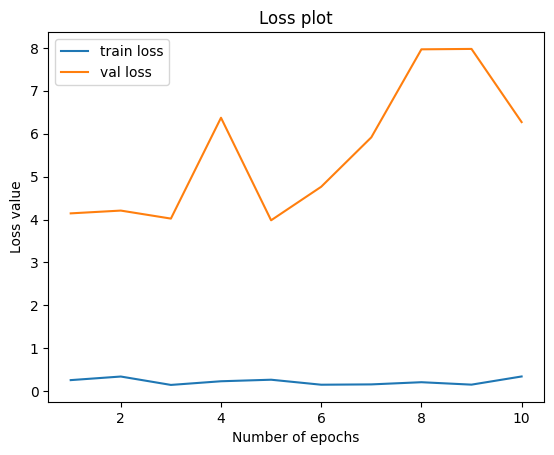

In [ ]:
epochs=[a for a in range(1,num_epochs+1)]
plt.plot(epochs,total_train_loss,label='train loss')
plt.plot(epochs,total_val_loss,label='val loss')
plt.title('Loss plot')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')

plt.legend()
plt.show()

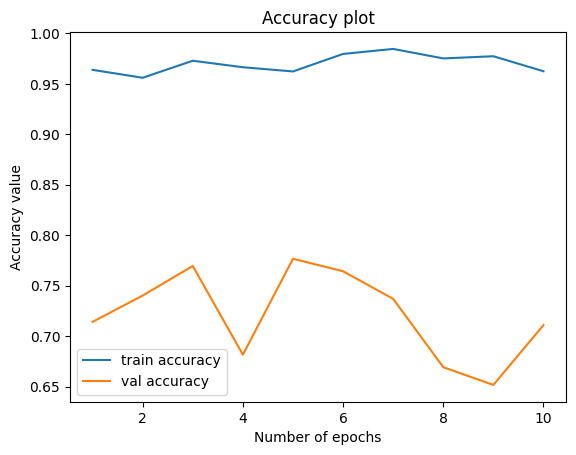

In [ ]:
epochs=[a for a in range(1,num_epochs+1)]
plt.plot(epochs,total_train_accuracy,label='train accuracy')
plt.plot(epochs,total_val_accuracy,label='val accuracy')
plt.title('Accuracy plot')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy value')

plt.legend()
plt.show()

# **Evaluation Metrics**

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_loader)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Reds', ax=ax)
    plt.xticks(rotation=20)

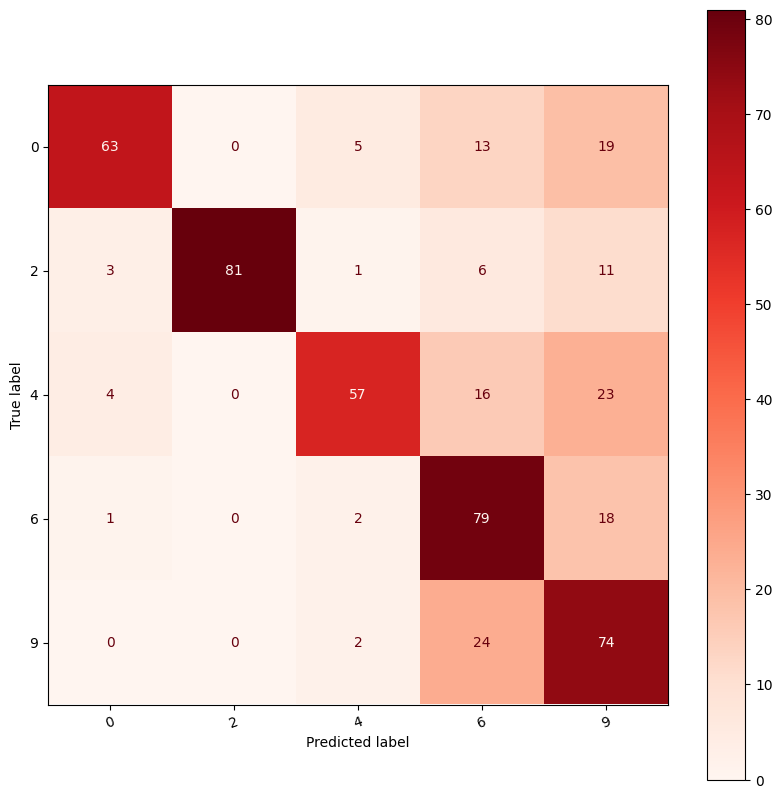

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy
accuracy_score(labels,pred_labels)

0.7051792828685259

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels,average='weighted')

0.7152141104274422

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels,average='macro')

0.7145339832625947

In [ ]:
from sklearn.metrics import f1_score
#f1 score
f1_score(labels,pred_labels,average='micro')

0.7051792828685259

In [ ]:
#precision
from sklearn.metrics import precision_score
precision_score(labels, pred_labels,average='weighted')

0.7651153004025572

In [ ]:
#recall
from sklearn.metrics import recall_score
recall_score(labels, pred_labels,average='weighted')

0.7051792828685259

# **Inference**

In [ ]:
model_path=os.path.join('/content/drive/MyDrive/smart_data_solutions/ML/models/model_convnet.pt')
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
def prediction(img_path,transformer):
  image=Image.open(img_path)

  # Convert grayscale image to RGB
  image = image.convert("RGB")
    
  image_tensor=transformer(image).float()
  # print(image_tensor)
  
  
  image_tensor=image_tensor.unsqueeze_(0)
  # print(image_tensor)

  image_tensor=image_tensor.to(device)
  
  # if torch.cuda.is_available():
  #     image_tensor.cuda()
      
  input=Variable(image_tensor)
  
  
  y_pred=model(input)

  # y_prob = F.softmax(y_pred, dim=-1)
  
  index=y_pred.cpu().data.numpy().argmax()
  
  pred=classes[index]
  
  return pred

In [ ]:
imp='/content/drive/MyDrive/smart_data_solutions/ML/data/0_category.TIF'

predic=prediction(imp,transformer)

print(predic)

0
